In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [4]:
df = pd.read_pickle('../data/train_merged.pkl')

In [5]:
fraud_df = df[df['isFraud'] == 1]
legit_df = df[df['isFraud'] == 0]
target_total_nodes = 2000
n_fraud = len(fraud_df)

In [6]:
n_fraud_to_sample = min(n_fraud, 500)
n_legit_to_sample = target_total_nodes - n_fraud_to_sample
sampled_fraud = fraud_df.sample(n=n_fraud_to_sample, random_state=42)
sampled_legit = legit_df.sample(n=n_legit_to_sample, random_state=42)
df_viz = pd.concat([sampled_fraud, sampled_legit]).sample(frac=1, random_state=42)


  Added 1463 edges for shared 'card1' (Star Topology)
  Added 372 edges for shared 'DeviceInfo' (Star Topology)


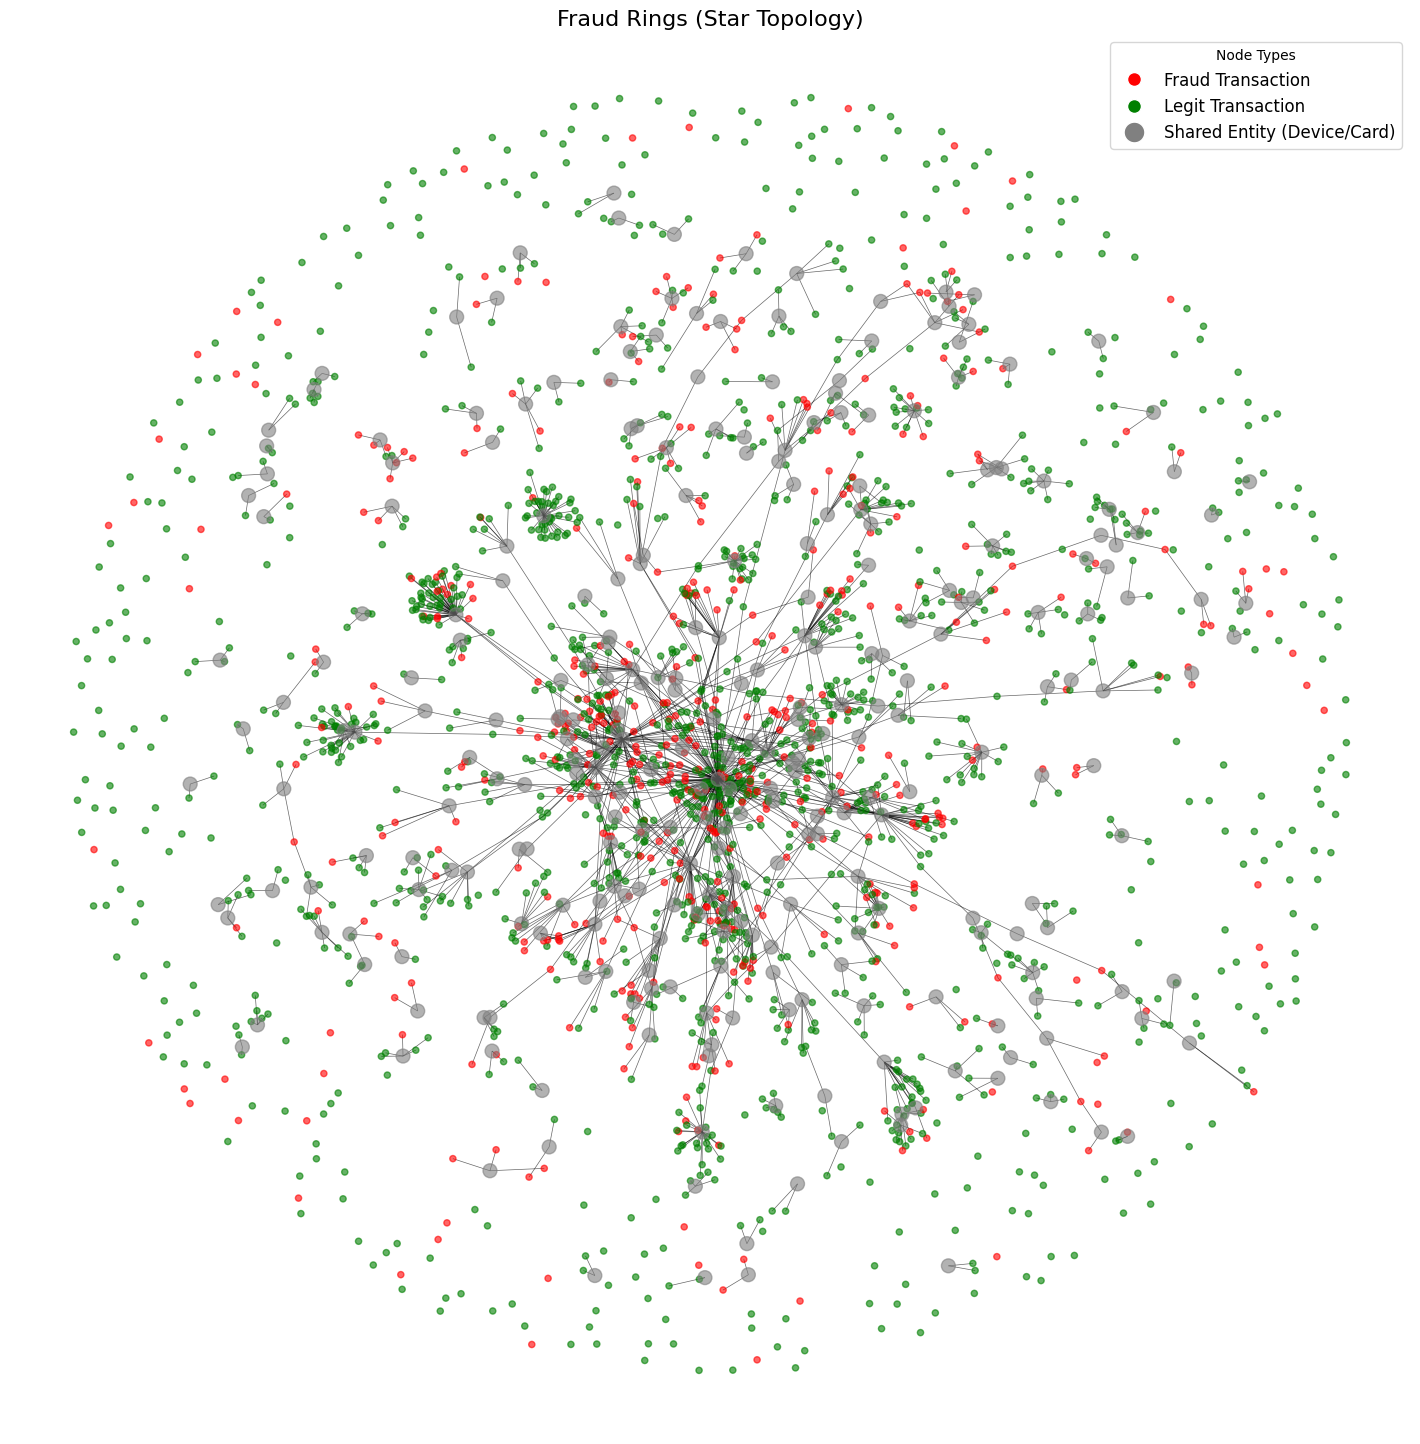

In [7]:
def build_links_star(graph, df, col_name, color='blue'):
    # Group IDs by Value
    value_map = {}
    for _, row in df.iterrows():
        val = row[col_name]
        if pd.isna(val): continue
        
        if val not in value_map:
            value_map[val] = []
        value_map[val].append(row['TransactionID'])
        
    # Create Edges 
    edge_count = 0
    for val, tx_ids in value_map.items():
        if len(tx_ids) > 1:
            # Create the Central Hub Node (The shared Device/Card)
            hub_node_id = f"{col_name}_{val}"
            graph.add_node(hub_node_id, color='grey', size=100, type='entity')
            
            for tx_id in tx_ids:
                graph.add_edge(tx_id, hub_node_id, relation=col_name)
                edge_count += 1
    
    print(f"  Added {edge_count} edges for shared '{col_name}' (Star Topology)")

G = nx.Graph()

# Add Transaction Nodes
for i, row in df_viz.iterrows():
    color = 'red' if row['isFraud'] == 1 else 'green'
    G.add_node(row['TransactionID'], color=color, size=20, type='transaction')

# Build Star Links
build_links_star(G, df_viz, 'card1')      
build_links_star(G, df_viz, 'DeviceInfo') 

plt.figure(figsize=(14, 14))
node_colors = [nx.get_node_attributes(G, 'color').get(n, 'grey') for n in G.nodes()]
node_sizes = [nx.get_node_attributes(G, 'size').get(n, 20) for n in G.nodes()]
pos = nx.spring_layout(G, k=0.15, seed=42) # Fixed seed for consistent layout
nx.draw(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.6, width=0.5)

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Fraud Transaction',
           markerfacecolor='red', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Legit Transaction',
           markerfacecolor='green', markersize=10),
    Line2D([0], [0], marker='o', color='w', label='Shared Entity (Device/Card)',
           markerfacecolor='grey', markersize=15),
]

plt.legend(handles=legend_elements, loc='upper right', title="Node Types", fontsize=12)
plt.title("Fraud Rings (Star Topology)", fontsize=16)
plt.show()

In [8]:
EDGE_CANDIDATES = ['DeviceInfo', 'card1', 'addr1', 'P_emaildomain']
LABEL_COL = 'isFraud'

In [9]:
def analyze_graph_structure(df, edge_cols):
    stats_list = []
    
    df_clean = df.copy()
    for col in edge_cols:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].fillna("Unknown")
    
    plt.figure(figsize=(15, 5 * len(edge_cols)))
    
    for i, col in enumerate(edge_cols):            
        print(f"Analyzing structure for edge source: {col}...")
        
        # Degree Analysis
        value_counts = df_clean[col].value_counts()
        
        max_degree = value_counts.max()
        avg_degree = value_counts.mean()
        
        # Homophily Analysis 
        grouped_fraud = df_clean.groupby(col)[LABEL_COL].mean()
        
        fraud_separation_score = grouped_fraud.std()
        
        stats_list.append({
            'Edge Source': col,
            'Max Degree (Supernode Risk)': max_degree,
            'Avg Degree': round(avg_degree, 2),
            'Fraud Separation Score (StdDev)': round(fraud_separation_score, 4)
        })
        
        # Plot: Degree Distribution (Log Scale)
        plt.subplot(len(edge_cols), 2, 2*i + 1)
        sns.histplot(value_counts, bins=50, log_scale=True, color='teal')
        plt.title(f"Degree Distribution for {col} (Log Scale)")
        plt.xlabel("Number of Connections (Degree)")
        plt.ylabel("Count of Values")
        plt.axvline(x=1000, color='r', linestyle='--', label='Supernode Threshold (1k)')
        plt.legend()
        
        # Plot: Fraud Purity per Component
        plt.subplot(len(edge_cols), 2, 2*i + 2)
        sns.histplot(grouped_fraud, bins=20, kde=False, color='orange')
        plt.title(f"Fraud Purity per {col} Group")
        plt.xlabel("Fraud Rate (0=All Legit, 1=All Fraud)")
        plt.ylabel("Number of Groups")

    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(stats_list)

Analyzing structure for edge source: DeviceInfo...
Analyzing structure for edge source: card1...
Analyzing structure for edge source: addr1...
Analyzing structure for edge source: P_emaildomain...


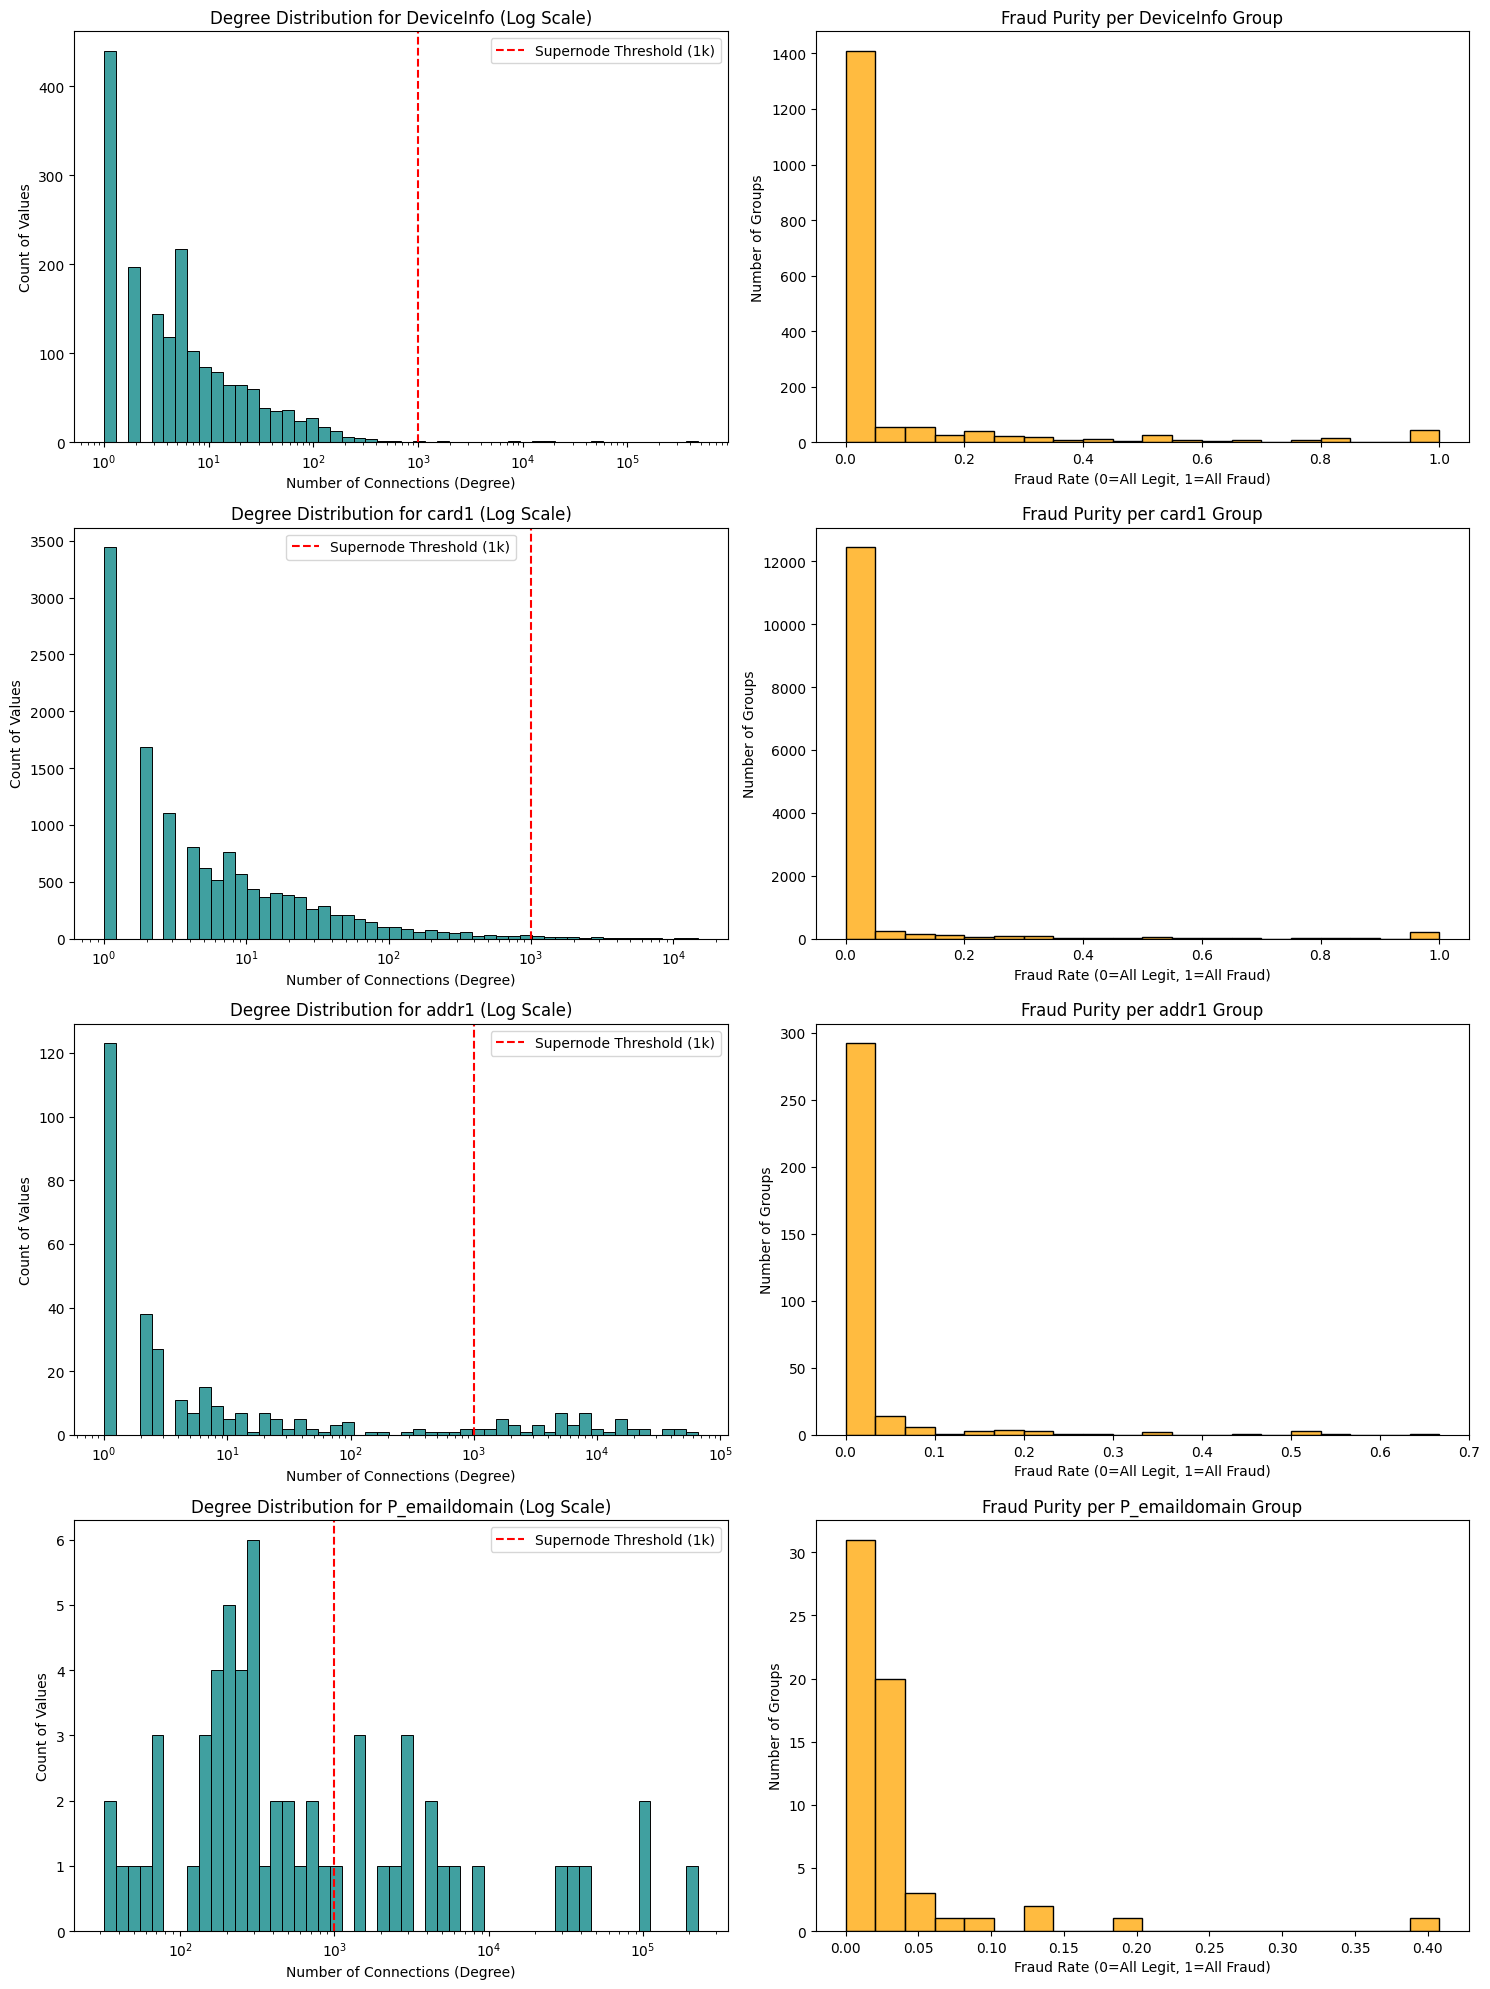


--- STRUCTURAL ANALYSIS RESULTS ---


,Edge Source,Max Degree (Supernode Risk),Avg Degree,Fraud Separation Score (StdDev)
0,DeviceInfo,471874,330.46,0.2155
1,card1,14932,43.57,0.1425
2,addr1,65706,1773.39,0.0838
3,P_emaildomain,228355,9842.33,0.0605


In [10]:
eda_stats = analyze_graph_structure(df, EDGE_CANDIDATES)

print("\n--- STRUCTURAL ANALYSIS RESULTS ---")
display(eda_stats)

In [11]:
from tqdm import tqdm

def build_refined_fraud_graph(df, edge_config):
    G = nx.Graph()
    
    # Add Transaction Nodes 
    print("Adding Transaction Nodes...")
    for idx, row in df.iterrows():
        tx_id = f"TX_{row['TransactionID']}"
        G.add_node(tx_id, type='transaction', y=int(row['isFraud']))

    # Add Entity Nodes 
    for col, threshold in edge_config.items():
        print(f"Building Star Clusters for: {col}...")
        
        # Filter: Ignore values that are too often 
        val_counts = df[col].value_counts()
        valid_values = val_counts[val_counts <= threshold].index
        
        # Grouping
        valid_df = df[df[col].isin(valid_values)]
        
        # Construction
        for val, group in tqdm(valid_df.groupby(col)):
            if len(group) < 2: continue 
            
            # Create the Hub Node 
            hub_id = f"{col}_{val}"
            G.add_node(hub_id, type='entity', entity_type=col)
            
            # Connect all transactions
            for tx_id in group['TransactionID']:
                G.add_edge(f"TX_{tx_id}", hub_id, relation=col)

    print(f"\nFinal Graph Stats:")
    print(f"Nodes: {G.number_of_nodes()} (Should be ~2000-3000)")
    print(f"Edges: {G.number_of_edges()} (Should be ~2x transactions)")
    return G

REFINED_CONFIG = {
    'card1': 50,  
    'DeviceInfo': 300, 
    }

G_clean = build_refined_fraud_graph(df_viz, REFINED_CONFIG)

Adding Transaction Nodes...
Building Star Clusters for: card1...


100%|██████████| 804/804 [00:01<00:00, 705.80it/s] 


Building Star Clusters for: DeviceInfo...


100%|██████████| 131/131 [00:00<00:00, 1004.55it/s]


Final Graph Stats:
Nodes: 2296 (Should be ~2000-3000)
Edges: 1783 (Should be ~2x transactions)


In [15]:
import torch
import numpy as np
from torch_geometric.data import HeteroData

def convert_to_heterodata(G, df): 
    
    print("Converting NetworkX graph to HeteroData...")
    
    # Separate nodes 
    tx_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'transaction']
    entity_nodes = [n for n, attr in G.nodes(data=True) if attr['type'] == 'entity']
    
    # Mappings
    tx_map = {n: i for i, n in enumerate(tx_nodes)}
    entity_map = {n: i for i, n in enumerate(entity_nodes)}
    
    # Extract labels
    y = [G.nodes[n].get('y', 0) for n in tx_nodes]
    y = torch.tensor(y, dtype=torch.long)
    
    src_list = []
    dst_list = []
    
    for u, v in G.edges():
        if u in tx_map and v in entity_map:
            src_list.append(tx_map[u])
            dst_list.append(entity_map[v])
        elif v in tx_map and u in entity_map:
            src_list.append(tx_map[v])
            dst_list.append(entity_map[u])
            
    edge_index = torch.tensor([src_list, dst_list], dtype=torch.long)
    
    data = HeteroData()
    
    feature_cols = ['TransactionAmt', 'dist1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'D1', 'D2', 'card1']
    
    # Set TransactionID as the index
    temp_df = df.copy()
    if 'TransactionID' in temp_df.columns:
        temp_df = temp_df.set_index('TransactionID')
    
    df_features = temp_df[feature_cols].fillna(-1)
    
    ordered_tx_ids = [None] * len(tx_map)
    for node_name, index in tx_map.items():
        raw_id = int(node_name.replace("TX_", "")) 
        ordered_tx_ids[index] = raw_id
        
    # Normalize
    aligned_features = df_features.loc[ordered_tx_ids].values 
    
    mean = np.mean(aligned_features, axis=0)
    std = np.std(aligned_features, axis=0) + 1e-6
    normalized_features = (aligned_features - mean) / std  
    
    # Assignment
    data['transaction'].x = torch.tensor(normalized_features, dtype=torch.float)
    data['transaction'].y = y
    data['entity'].x = torch.randn(len(entity_nodes), len(feature_cols)) 
    
    # Edge Assignment
    data['transaction', 'connected_to', 'entity'].edge_index = edge_index
    data['entity', 'rev_connected_to', 'transaction'].edge_index = torch.flip(edge_index, [0])
    
    print(f"Success! Data Object Created with {len(feature_cols)} real features.")
    return data

pyg_data = convert_to_heterodata(G_clean, df)
print(pyg_data)

Converting NetworkX graph to HeteroData...
Success! Data Object Created with 11 real features.
HeteroData(
  transaction={
    x=[2000, 11],
    y=[2000],
  },
  entity={ x=[296, 11] },
  (transaction, connected_to, entity)={ edge_index=[2, 1783] },
  (entity, rev_connected_to, transaction)={ edge_index=[2, 1783] }
)


In [18]:
import os
save_path = '../data/fraud_graph_data.pt'
torch.save(pyg_data, save_path)